# MODIS Cloud Top Pressure Retrieval

This notebook demsontrates the application of QRNNs to retrieve cloud-top pressure (CTP) from MODIS infrared observations. A similar retrieval will be used in the next version of the EUMETSAT PPS package, for the production
of near-real time (NRT) Meteorological data to support Nowcasting activities.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from quantnn.models.keras.xception import XceptionNet

model = XceptionNet(15, 101)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

## Downloading the data

In [2]:
from quantnn.examples.modis_ctp import download_data
download_data()

## Loading and preparing the training data

In [3]:
import pathlib
from quantnn.normalizer import Normalizer
training_data = np.load("data/ctp_training_data.npz")
x_train, y_train = training_data["x"], training_data["y"]

In [4]:
from quantnn.normalizer import Normalizer
normalizer = Normalizer(x_train)
x_train = normalizer(x_train)

## Defining a neural network model

In [5]:
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

In [6]:
import torch
import torch.nn as nn

n_layers = 4
n_neurons = 256

# First block
layers = [nn.Linear(16, n_neurons), nn.BatchNorm1d(n_neurons), nn.ReLU(), ]
# Center blocks
for _ in range(n_layers):
    layers.extend([nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons), nn.ReLU()])
# Final block
layers.append(nn.Linear(n_neurons, len(quantiles)))

model = nn.Sequential(*layers)

## Training the neural network

In [8]:
from quantnn import QRNN
qrnn = QRNN(quantiles=quantiles,
            model=model)

In [9]:
from torch.utils.data import TensorDataset, DataLoader
x_tensor = torch.tensor(x_train).float()
y_tensor = torch.tensor(y_train).float()
training_data = TensorDataset(x_tensor, y_tensor)
training_loader = DataLoader(training_data,
                             batch_size=256,
                             shuffle=True,
                             num_workers=4)

In [13]:
n_epochs = 10
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           optimizer=optimizer,
           scheduler=scheduler,
           n_epochs=n_epochs)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
qrnn.train(training_loader,
           optimizer=optimizer,
           scheduler=scheduler,
           n_epochs=n_epochs)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
results = qrnn.train(training_loader,
                     optimizer=optimizer,
                     scheduler=scheduler,
                     n_epochs=n_epochs)

Epoch  1 / 10: train. loss = 34.9570, lr. = 0.1000, time = 78.039981 s
Epoch  2 / 10: train. loss = 32.6822, lr. = 0.0976, time = 79.268005 s
Epoch  3 / 10: train. loss = 32.1679, lr. = 0.0905, time = 109.817379 s
Epoch  4 / 10: train. loss = 31.8007, lr. = 0.0794, time = 100.716209 s
Epoch  5 / 10: train. loss = 31.4462, lr. = 0.0655, time = 102.477865 s
Epoch  6 / 10: train. loss = 31.1048, lr. = 0.0500, time = 101.54901 s
Epoch  7 / 10: train. loss = 30.7651, lr. = 0.0345, time = 96.753168 s
Epoch  8 / 10: train. loss = 30.4444, lr. = 0.0206, time = 84.953588 s
Epoch  9 / 10: train. loss = 30.1356, lr. = 0.0095, time = 91.85199 s
Epoch 10 / 10: train. loss = 29.9127, lr. = 0.0024, time = 88.990988 s
Epoch  1 / 10: train. loss = 29.6596, lr. = 0.0100, time = 64.579947 s
Epoch  2 / 10: train. loss = 29.5332, lr. = 0.0098, time = 62.689981 s
Epoch  3 / 10: train. loss = 29.3946, lr. = 0.0090, time = 62.506368 s
Epoch  4 / 10: train. loss = 29.2401, lr. = 0.0079, time = 66.526714 s
Epoc

{'training_errors': [34.98654800432873,
  32.68223443345443,
  32.16753873131808,
  31.80072589948357,
  31.446150450983392,
  31.104709943497134,
  30.765138371849535,
  30.444760929156242,
  30.13554121656026,
  29.912757878880935,
  29.659476506289845,
  29.532933314842808,
  29.39453489740183,
  29.23990836272946,
  29.07230592480996,
  28.895426553056645,
  28.713594428179224,
  28.538525243881082,
  28.394846456409642,
  28.299678826872366,
  28.27038262996002,
  28.26387201668671,
  28.25860305209345,
  28.253024354407373,
  28.247815727604966,
  28.24324464870271,
  28.239198454777455,
  28.23592737422087,
  28.23346550197583,
  28.232021529795208],
 'validation_errors': []}

## Applying the CTP retrieval

To validate the CTP retrieval, we will apply the retrieval to observations of Hurricane Nicole of the 2016 Hurricane season and compare the results to the cloud-top pressure determined by the CALIOP lidar on the CALIPSO satellite, which is also used as reference to generate the training data.


In [14]:
validation_data = np.load("data/ctp_validation_data.npz")

# Overview over full MODIS observations.
lons_rgb = validation_data["longitude_rgb"]
lats_rgb = validation_data["latitude_rgb"]
modis_rgb = validation_data["modis_rgb"]
modis_bt_11 = validation_data["bt_11_rgb"]
modis_bt_12 = validation_data["bt_12_rgb"]

# Caliop obervations used as reference
lons_c = validation_data["longitude"]
lats_c = validation_data["latitude"]
ctp_c = validation_data["ctp"]
input_data = validation_data["input_data"]

### Hurricane Nicole

The plot below shows an overview of the scene the we will be using to validate the retrieval. The scene depicts an overpass of the CALIOP lidar over Hurricane Nicole from the 2016 Hurrican season. The line plotted ontop of the true-color image in panel (a) displays the swath of the CALIOP lidar. As you can see, it passed directly through the eye of the Hurricane.

Panel (b) and (c) show the MODIS observations that are used as input for the retrieval. The two channels are located in the far infrared region and thus measure thermal emission from the atmosphere. Nicole's high clouds are visible as cold regions in the image since the radiation is emitted higher up in the atmosphere, where it is colder.`

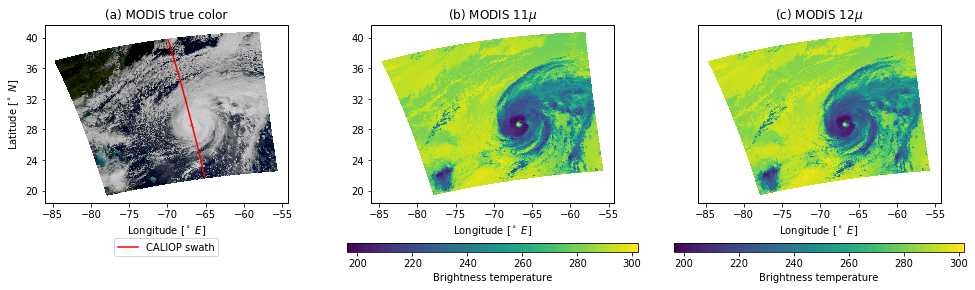

In [15]:
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec

f = plt.figure(figsize=(14, 4))
gs = GridSpec(2, 3, height_ratios=[1.0, 0.05])

ax = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
colors = modis_rgb[:-1, :-1].reshape(-1, 4) / 256.0
l = plt.plot(lons_c, lats_c, c="r")
ax.pcolormesh(lons_rgb, lats_rgb, lons_rgb, color=colors)
ax.set_xticks(np.linspace(-85, -55, 7))
ax.set_xlabel("Longitude [$^\circ\ E$]")
ax.set_yticks(np.linspace(20, 40, 6))
ax.set_ylabel("Latitude [$^\circ\ N$]")
ax.set_title("(a) MODIS true color")
ax = plt.subplot(gs[1, 0])
ax.set_axis_off()
ax.legend(handles=l, labels=["CALIOP swath"], loc="center")

ax = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
m = ax.pcolormesh(lons_rgb, lats_rgb, modis_bt_11)
ax.set_xticks(np.linspace(-85, -55, 7))
ax.set_xlabel("Longitude [$^\circ\ E$]")
ax.set_yticks(np.linspace(20, 40, 6))
ax.set_title("(b) MODIS $11\mu$")
ax = plt.subplot(gs[1, 1])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Brightness temperature")

ax = plt.subplot(gs[0, 2], projection=ccrs.PlateCarree())
img = ax.pcolormesh(lons_rgb, lats_rgb, modis_bt_12)
ax.set_xticks(np.linspace(-85, -55, 7))
ax.set_xlabel("Longitude [$^\circ\ E$]")
ax.set_title("(c) MODIS $12\mu$")
ax = plt.subplot(gs[1, 2])
plt.colorbar(m, cax=ax, orientation="horizontal", label="Brightness temperature")

f.canvas.draw()
plt.tight_layout()

### Running the retrieval

The validation data comes with pre-processed observation along the CALOP swath. Evaluating the retrieval therfore only requires normalizing the data (using the same normalizer that was used during training) and evaluating the network prediction.

In [16]:
y_pred = qrnn.predict(normalizer(input_data))

# CALIOP reference data
y_ref = ctp_c[:, 0]
y_ref[y_ref < 0.0] = np.nan

The plot below shows the QRNN-predicted cloud-top pressure as confidence intervals together with the reference data from the CALIOP LIDAR (black markers). Although there is considerable uncertainty in the retrieval, all reference values lie withing the predicted intervals.

However, the cloud-top pressure of the hurricane seems to be rather consistently underestimating the reference pressure, which indicates that the the uncertainty estimates are not very well calibrated in this region. This is expected, to some extent, because the QRNN learned to predicted uncertainty based on the a-priori distribution of cloud-top pressures in the training data, which is quite different from those of the Hurricane.

Text(0.5, 0, 'Latitude [$^\\circ\\ N$]')

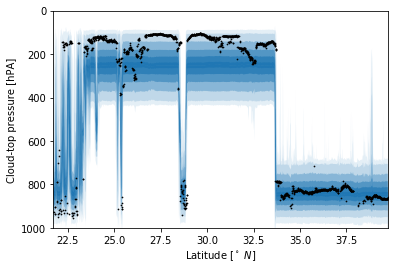

In [17]:
from quantnn.plotting import plot_confidence_intervals

f, ax = plt.subplots(1, 1)
plot_confidence_intervals(ax, lats_c, y_pred, qrnn.quantiles)
ax.scatter(lats_c, y_ref, c="k", marker=".", s=2)

ax.set_xlim([lats_c.min(), lats_c.max()])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
ax.set_ylabel("Cloud-top pressure [hPA]")
ax.set_xlabel("Latitude [$^\circ\ N$]")

## Comparison to XGBoost

We conclude this example by comparing the QRNN performance to that of another machine learning method: gradient-boosted regression trees.

In [18]:
import xgboost as xgb
xgb_retrieval = xgb.XGBRegressor(n_estimators=100,
                                 reg_lambda=1,
                                 gamma=0,
                                 max_depth=3)
xgb_retrieval.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [22]:
from quantnn import posterior_mean
y_pred_xgb = xgb_retrieval.predict(normalizer(input_data))
y_pred_qrnn = posterior_mean(y_pred.numpy(), qrnn.quantiles)

Text(0.5, 0, 'Latitude [$^\\circ\\ N$]')

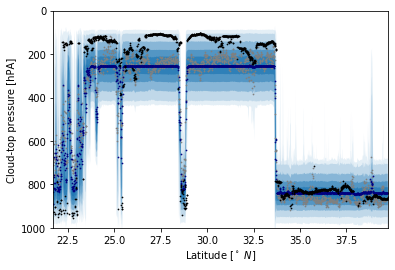

In [23]:
f, ax = plt.subplots(1, 1)
plot_confidence_intervals(ax, lats_c, y_pred, qrnn.quantiles)
ax.scatter(lats_c, y_pred_xgb, c="grey", marker=".", s=2)
ax.scatter(lats_c, y_pred_qrnn, c="navy", marker=".", s=2)
ax.scatter(lats_c, y_ref, c="k", marker=".", s=2)

ax.set_xlim([lats_c.min(), lats_c.max()])
ax.set_ylim([0, 1000])
ax.invert_yaxis()
ax.set_ylabel("Cloud-top pressure [hPA]")
ax.set_xlabel("Latitude [$^\circ\ N$]")